# GARCH

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import acf

In [26]:
sp500prices = pd.read_csv("data/data_other/sp500prCl.csv", sep=";")
sp500prices['Data'] = pd.to_datetime(sp500prices['Data'], format='%Y-%m-%d')
sp500prices.set_index('Data', inplace=True)

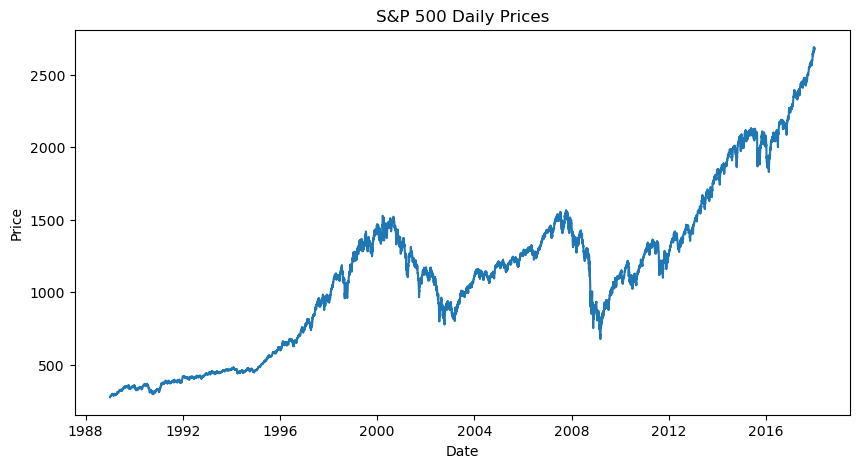

In [27]:
plt.figure(figsize=(10,5))
plt.plot(sp500prices['Price'])
plt.title("S&P 500 Daily Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [28]:
sp500ret = np.log(sp500prices['Price']).diff().dropna()
daily_std = sp500ret.std()
print("Daily Standard Deviation:", daily_std)

annual_volatility = np.sqrt(252) * daily_std
print("Annualized Volatility:", annual_volatility)

Daily Standard Deviation: 0.011003508200850708
Annualized Volatility: 0.1746752774922644


In [29]:
vol_2009 = np.sqrt(252) * sp500ret.loc['2009'].std()
vol_2017 = np.sqrt(252) * sp500ret.loc['2017'].std()
print("Annualized Volatility (2009):", vol_2009)
print("Annualized Volatility (2017):", vol_2017)

Annualized Volatility (2009): 0.2726419295650889
Annualized Volatility (2017): 0.06687345194338136


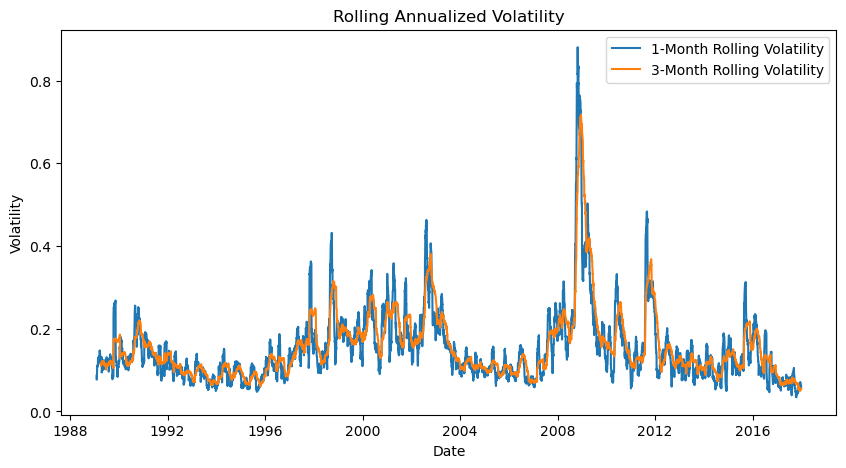

In [30]:
rolling_vol_1m = sp500ret.rolling(window=22).std() * np.sqrt(252)
rolling_vol_3m = sp500ret.rolling(window=66).std() * np.sqrt(252)

plt.figure(figsize=(10,5))
plt.plot(rolling_vol_1m, label="1-Month Rolling Volatility")
plt.plot(rolling_vol_3m, label="3-Month Rolling Volatility")
plt.legend()
plt.title("Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


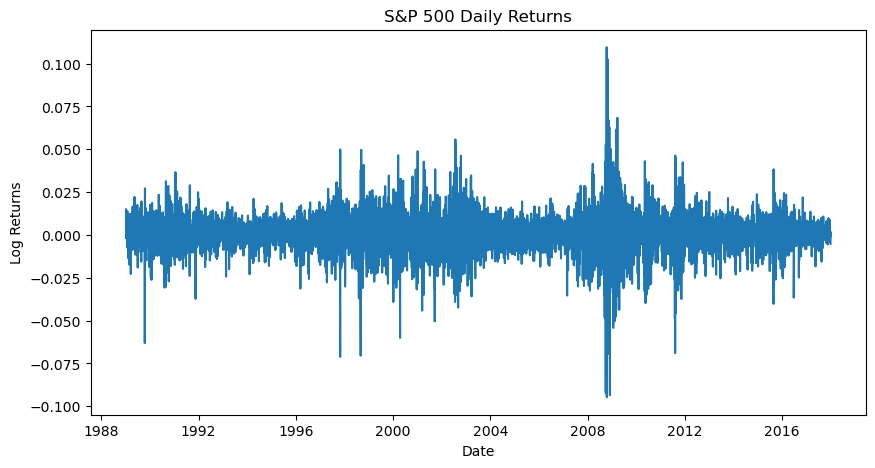

In [31]:
plt.figure(figsize=(10,5))
plt.plot(sp500ret)
plt.title("S&P 500 Daily Returns")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.show()

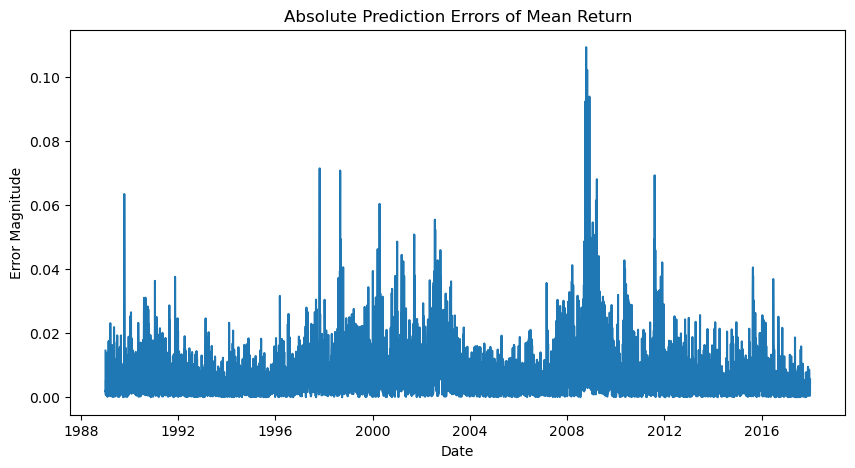

In [37]:
mean_return = sp500ret.mean()
prediction_errors = sp500ret - mean_return

plt.figure(figsize=(10,5))
plt.plot(abs(prediction_errors))
plt.title("Absolute Prediction Errors of Mean Return")
plt.xlabel("Date")
plt.ylabel("Error Magnitude")
plt.show()

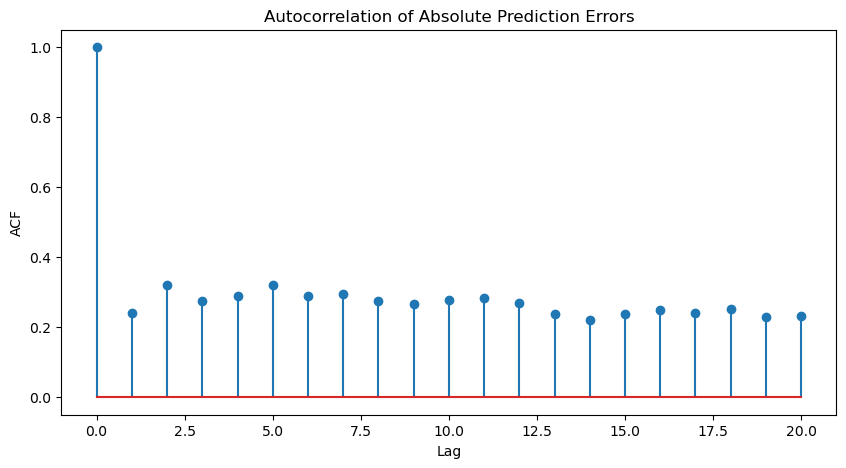

In [33]:
acf_values = acf(abs(prediction_errors), nlags=20)
plt.figure(figsize=(10,5))
plt.stem(acf_values)
plt.title("Autocorrelation of Absolute Prediction Errors")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

GARCH model parameters

In [35]:
alpha = 0.1
beta = 0.8
omega = np.var(sp500ret) * (1 - alpha - beta)
e = sp500ret - mean_return
e2 = e**2
nobs = len(sp500ret)
predvar = np.empty(nobs)
predvar[:] = np.nan

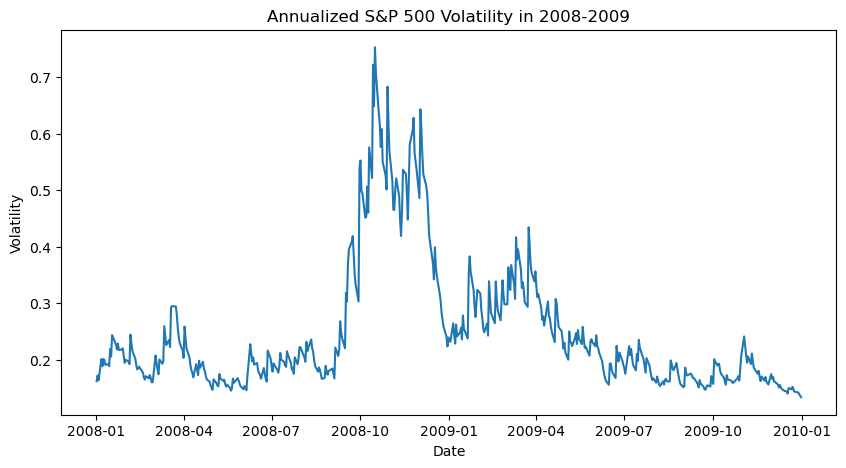

In [36]:
# Compute predicted variances
predvar[0] = np.var(sp500ret)
for t in range(1, nobs):
    predvar[t] = omega + alpha * e2.iloc[t-1] + beta * predvar[t-1]

# Create annualized predicted volatility
ann_predvol = np.sqrt(252) * np.sqrt(predvar)
ann_predvol_series = pd.Series(ann_predvol, index=sp500ret.index)

# Plot annual predicted volatility for 2008 and 2009
plt.figure(figsize=(10,5))
plt.plot(ann_predvol_series.loc['2008':'2009'])
plt.title("Annualized S&P 500 Volatility in 2008-2009")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

In [38]:
# 1. **Standard GARCH(1,1) model with constant mean**
garch_model = arch_model(sp500ret * 100, vol='Garch', p=1, q=1, mean='constant', dist='normal')
garchfit = garch_model.fit()
print(garchfit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27985410174.344517
Iteration:      2,   Func. Count:     15,   Neg. LLF: 886709025.4276028
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9661.95974410994
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1955593727.9493499
Iteration:      5,   Func. Count:     35,   Neg. LLF: 11440.858633472606
Iteration:      6,   Func. Count:     42,   Neg. LLF: 9608.213829093425
Iteration:      7,   Func. Count:     48,   Neg. LLF: 9621.585790943607
Iteration:      8,   Func. Count:     54,   Neg. LLF: 9584.757698053141
Iteration:      9,   Func. Count:     60,   Neg. LLF: 9583.543428936004
Iteration:     10,   Func. Count:     65,   Neg. LLF: 9583.535592623975
Iteration:     11,   Func. Count:     70,   Neg. LLF: 9583.53545326033
Iteration:     12,   Func. Count:     75,   Neg. LLF: 9583.535423602912
Iteration:     13,   Func. Count:     79,   Neg. LLF: 9583.535423603662
Optimization terminated successfully    (Exit mode 0)
         

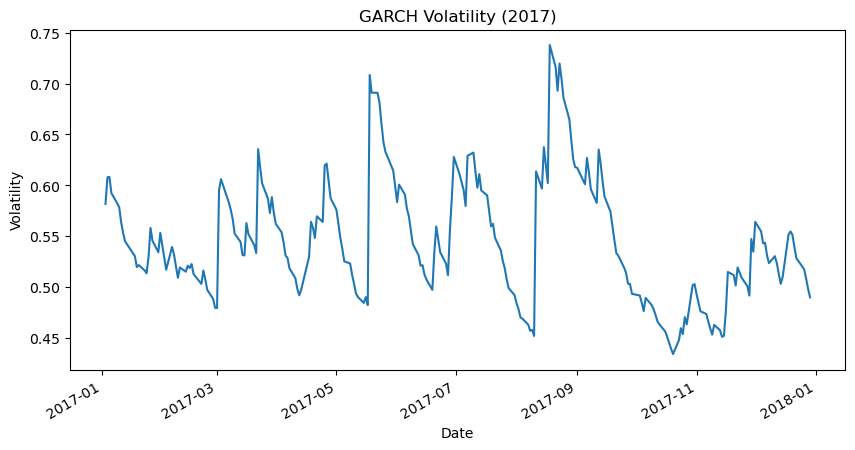

In [40]:
# Retrieve estimated volatilities and fitted mean
garch_vol = garchfit.conditional_volatility
garch_mean = garchfit.params['mu']

# Plot volatility for 2017
garch_vol.loc['2017'].plot(figsize=(10, 5), title="GARCH Volatility (2017)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

In [45]:
# Compute unconditional volatility
unconditional_vol = np.sqrt(garchfit.params['omega'] / (1 - garchfit.params['alpha[1]'] - garchfit.params['beta[1]']))
print("Unconditional Volatility:", unconditional_vol)

# Last 10 volatility estimates
print(garch_vol.tail(10))

# Forecast volatility 5 days ahead
forecast = garchfit.forecast(horizon=5)
print("5-Day Ahead Forecasted Volatility:", np.sqrt(forecast.variance.values[-1]))

Unconditional Volatility: 1.054422075034495
Data
2017-12-15    0.509668
2017-12-18    0.551375
2017-12-19    0.554520
2017-12-20    0.551187
2017-12-21    0.539258
2017-12-22    0.528300
2017-12-26    0.517313
2017-12-27    0.508298
2017-12-28    0.497990
2017-12-29    0.489685
Name: cond_vol, dtype: float64
5-Day Ahead Forecasted Volatility: [0.50663222 0.51612529 0.52534198 0.53429775 0.54300665]


**Volatility targeting**

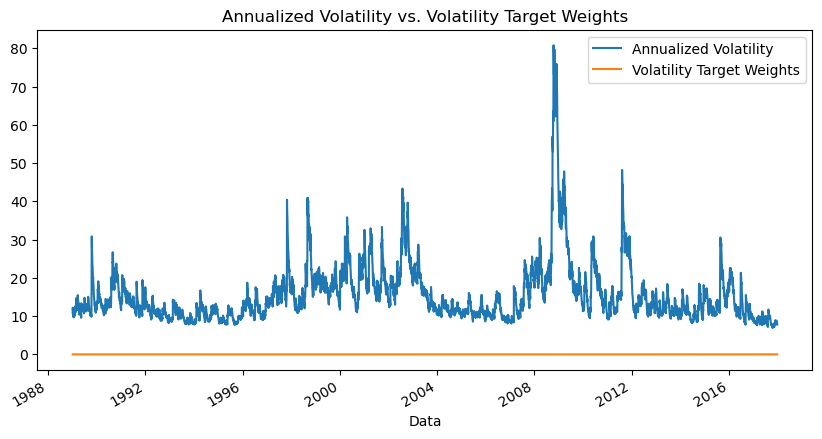

In [47]:
annual_vol = np.sqrt(252) * garch_vol
vol_target = 0.05
vt_weights = vol_target / annual_vol

plt.figure(figsize=(10, 5))
annual_vol.plot(label='Annualized Volatility')
vt_weights.plot(label='Volatility Target Weights')
plt.title("Annualized Volatility vs. Volatility Target Weights")
plt.legend()
plt.show()

**Student's t-distributed GARCH Model**

In [48]:
garch_model_sstd = arch_model(sp500ret * 100, vol='Garch', p=1, q=1, mean='constant', dist='t')
garchfit_sstd = garch_model_sstd.fit()
garch_vol_sstd = garchfit_sstd.conditional_volatility
print(garchfit_sstd.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 455516.04758979107
Iteration:      2,   Func. Count:     18,   Neg. LLF: 150464.02539533106
Iteration:      3,   Func. Count:     27,   Neg. LLF: 9788.162063430751
Iteration:      4,   Func. Count:     34,   Neg. LLF: 9402.534785217726
Iteration:      5,   Func. Count:     41,   Neg. LLF: 15472.719510809777
Iteration:      6,   Func. Count:     48,   Neg. LLF: 9401.634095620686
Iteration:      7,   Func. Count:     55,   Neg. LLF: 9406.369502760606
Iteration:      8,   Func. Count:     62,   Neg. LLF: 9375.882476131927
Iteration:      9,   Func. Count:     68,   Neg. LLF: 9377.536588350053
Iteration:     10,   Func. Count:     75,   Neg. LLF: 12649.329800205767
Iteration:     11,   Func. Count:     83,   Neg. LLF: 9376.186787496512
Iteration:     12,   Func. Count:     90,   Neg. LLF: 9375.0141917109
Iteration:     13,   Func. Count:     97,   Neg. LLF: 9375.000024432069
Iteration:     14,   Func. Count:    103,   Neg. LLF: 9375.000

**Standardized Returns**

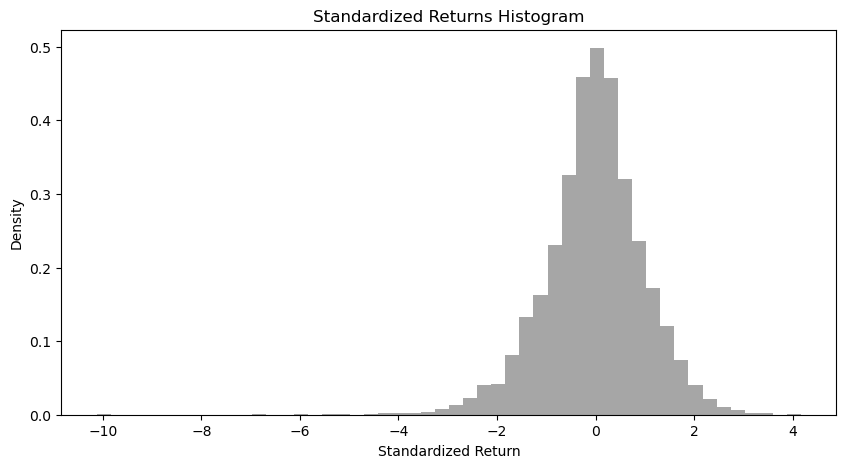

In [49]:
standardized_returns = garchfit.resid / garchfit.conditional_volatility

plt.figure(figsize=(10, 5))
plt.hist(standardized_returns, bins=50, density=True, alpha=0.7, color='gray')
plt.title("Standardized Returns Histogram")
plt.xlabel("Standardized Return")
plt.ylabel("Density")
plt.show()

**GJR-GARCH Model for Leverage Effect**

In [50]:
gjr_garch_model = arch_model(sp500ret * 100, vol='GARCH', p=1, o=1, q=1, mean='constant', dist='t')
gjrgarchfit = gjr_garch_model.fit()
print(gjrgarchfit.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 58802.639441036896
Iteration:      2,   Func. Count:     20,   Neg. LLF: 11185.892593764513
Iteration:      3,   Func. Count:     28,   Neg. LLF: 3170644.4440517994
Iteration:      4,   Func. Count:     38,   Neg. LLF: 232934.51885588595
Iteration:      5,   Func. Count:     46,   Neg. LLF: 9367.307455786879
Iteration:      6,   Func. Count:     54,   Neg. LLF: 9375.023647786456
Iteration:      7,   Func. Count:     62,   Neg. LLF: 571843.509137842
Iteration:      8,   Func. Count:     71,   Neg. LLF: 9356.338227055941
Iteration:      9,   Func. Count:     79,   Neg. LLF: 9293.67767984926
Iteration:     10,   Func. Count:     86,   Neg. LLF: 9293.417977266381
Iteration:     11,   Func. Count:     93,   Neg. LLF: 9405.958155848819
Iteration:     12,   Func. Count:    102,   Neg. LLF: 9446.200144573162
Iteration:     13,   Func. Count:    111,   Neg. LLF: 9293.18659569853
Iteration:     14,   Func. Count:    118,   Neg. LLF: 9293.1840

**AR(1)-GJR GARCH Model**

In [52]:
ar_gjr_model = arch_model(sp500ret * 100, vol='GARCH', p=1, o=1, q=1, mean='AR', lags=1, dist='t')
ar_gjr_fit = ar_gjr_model.fit()
print("First four coefficients: \n", ar_gjr_fit.params.iloc[:4])

Iteration:      1,   Func. Count:      9,   Neg. LLF: 68705.17469282547
Iteration:      2,   Func. Count:     23,   Neg. LLF: 243235.0963914945
Iteration:      3,   Func. Count:     35,   Neg. LLF: 11784.95198994821
Iteration:      4,   Func. Count:     44,   Neg. LLF: 4091412.1440270254
Iteration:      5,   Func. Count:     55,   Neg. LLF: 230981.4631634409
Iteration:      6,   Func. Count:     64,   Neg. LLF: 9363.053925761156
Iteration:      7,   Func. Count:     73,   Neg. LLF: 9742.152750320158
Iteration:      8,   Func. Count:     82,   Neg. LLF: 9389.564140670507
Iteration:      9,   Func. Count:     91,   Neg. LLF: 9414.176768537644
Iteration:     10,   Func. Count:    100,   Neg. LLF: 9291.088359955344
Iteration:     11,   Func. Count:    109,   Neg. LLF: 9297.286458682982
Iteration:     12,   Func. Count:    118,   Neg. LLF: 9288.292529124234
Iteration:     13,   Func. Count:    127,   Neg. LLF: 9365.11480539432
Iteration:     14,   Func. Count:    137,   Neg. LLF: 9288.28774

**APARCH Model (Asymmetric Power ARCH)**

arch_model does not directly support APARCH; use p=1, o=1, q=1 with "GARCH" as a close approximation.

Iteration:      1,   Func. Count:      9,   Neg. LLF: 68705.17469282547
Iteration:      2,   Func. Count:     23,   Neg. LLF: 243235.0963914945
Iteration:      3,   Func. Count:     35,   Neg. LLF: 11784.95198994821
Iteration:      4,   Func. Count:     44,   Neg. LLF: 4091412.1440270254
Iteration:      5,   Func. Count:     55,   Neg. LLF: 230981.4631634409
Iteration:      6,   Func. Count:     64,   Neg. LLF: 9363.053925761156
Iteration:      7,   Func. Count:     73,   Neg. LLF: 9742.152750320158
Iteration:      8,   Func. Count:     82,   Neg. LLF: 9389.564140670507
Iteration:      9,   Func. Count:     91,   Neg. LLF: 9414.176768537644
Iteration:     10,   Func. Count:    100,   Neg. LLF: 9291.088359955344
Iteration:     11,   Func. Count:    109,   Neg. LLF: 9297.286458682982
Iteration:     12,   Func. Count:    118,   Neg. LLF: 9288.292529124234
Iteration:     13,   Func. Count:    127,   Neg. LLF: 9365.11480539432
Iteration:     14,   Func. Count:    137,   Neg. LLF: 9288.28774

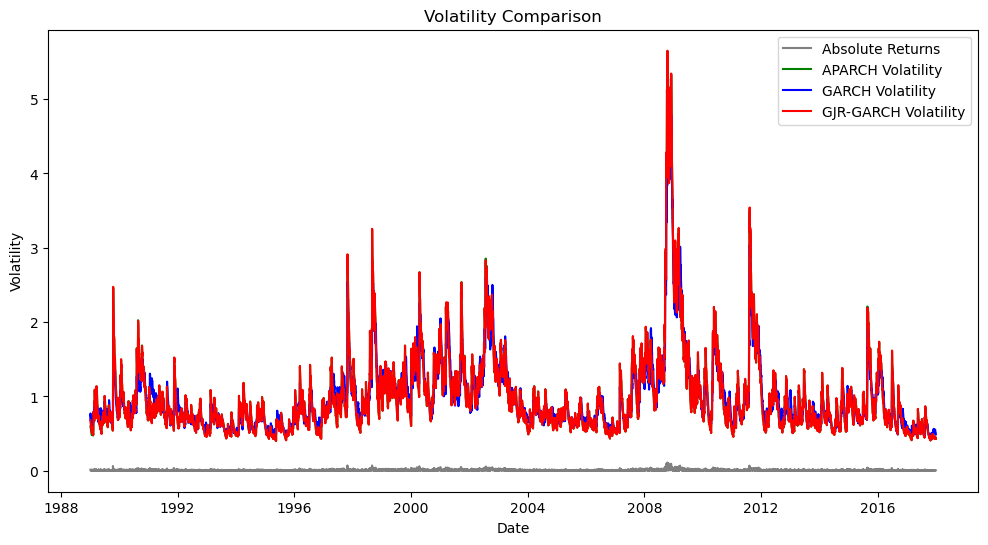

In [56]:
aparch_model = arch_model(sp500ret * 100, vol='GARCH', p=1, o=1, q=1, mean='AR', lags=1, dist='t')
aparch_fit = aparch_model.fit()
aparch_vol = aparch_fit.conditional_volatility
aparch_mean = aparch_fit.params['nu']

# Volatility Comparison Plot
plt.figure(figsize=(12, 6))
plt.plot(abs(sp500ret), color='grey', label='Absolute Returns')
plt.plot(aparch_vol, color='green', label='APARCH Volatility')
plt.plot(garch_vol, color='blue', label='GARCH Volatility')
plt.plot(gjrgarchfit.conditional_volatility, color='red', label='GJR-GARCH Volatility')
plt.title("Volatility Comparison")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()